In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

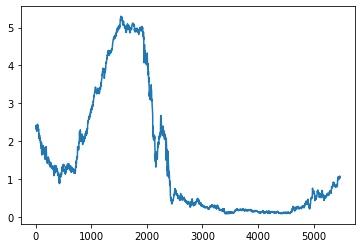

In [3]:
# load the dataset
dataframe = pd.read_csv('Treasury_ML(15yr).csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [5]:
# transform to 1D array
train = train.flatten()
test = test.flatten()

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    df = pd.DataFrame()
    df['X'] = dataset
    df['Y'] = df['X'].shift(-look_back)
    df.dropna(inplace=True)
    return np.array(df['X']), np.array(df['Y'])

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1))
trainX.shape

(3670, 1, 1)

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

W0827 16:43:25.294685  4876 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 16:43:25.315681  4876 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 16:43:25.318733  4876 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 16:43:25.639647  4876 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 16

Epoch 1/10
 - 9s - loss: 0.0164
Epoch 2/10
 - 7s - loss: 9.5631e-05
Epoch 3/10
 - 7s - loss: 9.4136e-05
Epoch 4/10
 - 8s - loss: 9.0151e-05
Epoch 5/10
 - 7s - loss: 8.7387e-05
Epoch 6/10
 - 7s - loss: 8.2988e-05
Epoch 7/10
 - 7s - loss: 8.1618e-05
Epoch 8/10
 - 7s - loss: 7.7734e-05
Epoch 9/10
 - 8s - loss: 7.4094e-05
Epoch 10/10
 - 7s - loss: 7.2457e-05


In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 0.0474 RMSE
Test Score: 0.0372 RMSE


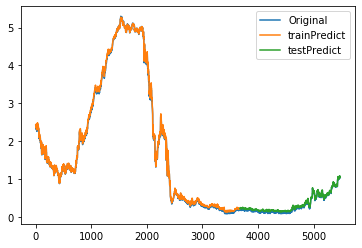

In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(trainPredict), :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back:-1, :] = testPredict
# plot baseline and predictions
#plt.figure(figsize=(13,8))
plt.plot(scaler.inverse_transform(dataset), label = 'Original')
plt.plot(trainPredictPlot, label = 'trainPredict')
plt.plot(testPredictPlot, label = 'testPredict')
plt.legend()
plt.show()

In [12]:
dataset1 = scaler.inverse_transform(dataset)
dataset1 = dataset1.flatten()
trainPredict1 = trainPredict.flatten()
testPredict1 = testPredict.flatten()

In [13]:
print('Training set accuracy:',
      '{}%'.format((1 - np.mean(abs(dataset1[:len(trainPredict1)]-trainPredict1)/trainPredict1))*100),
      '\nTesting set accuracy:',
      '{}%'.format((1 - np.mean(abs(dataset1[len(trainPredict1)+1:-1]-testPredict1)/testPredict1))*100))

Training set accuracy: 95.3129269182682% 
Testing set accuracy: 84.29810702800751%
